# Lecture 8: Neural Network Library Implementation

In this lecture, we will to walk through neural network library design.




## Prepare the codebase

To get started, we can clone the related `lecture8` repo from GitHub. 

In [4]:
# Code to set up the assignment
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/
!mkdir -p 10714f22
%cd /content/drive/MyDrive/10714f22

# NOTE: Run the following line
# - uncomment the following line if you run this section for the first time
# - comment and skip the following line when you run this section for a second time
#   so you will have a local copy of lecture8 under 10714f22/lecture8 that you can
#   continue to edit and play with
# !git clone https://github.com/dlsyscourse/lecture8
!ln -s /content/drive/MyDrive/10714f22/lecture8 /content/needle
%cd /content/needle

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive
/content/drive/MyDrive/10714f22
ln: failed to create symbolic link '/content/needle/lecture8': File exists
/content/drive/MyDrive/10714f22/lecture8


We can then run the following command to make the path to the package available in Colab environment as well as `PYTHONPATH`.

In [1]:
%set_env PYTHONPATH ~/10-414/l8/python:/env/python
import sys
sys.path.append("~/10-414/l8/python")

env: PYTHONPATH=~/10-414/l8/python:/env/python


## Needle Refresh

We will continue to improve needle from lecture4 and hw1. Let us first begin
by review a few more elements of needle API.

### Mutating the data field of a `needle` Tensor


In [2]:
from python import needle as ndl

In [3]:
w = ndl.Tensor([1,2,3], dtype="float32")

In [4]:
g = ndl.Tensor([1,1,1], dtype="float32")

By default, we create needle Tensors that sets `requires_grad` to be true. This will cause us to record the gradient graph by default. 

In [5]:
w.requires_grad

True

Let's run a SGD style update for a few steps. We use `+ (-lr)` since `needle` does not support subtraction yet.

In [12]:
grad = ndl.Tensor([1, 1, 1], dtype="float32")
lr = 0.1
for i in range(5):
    w = w + (-lr) * grad

The problem with is approach is that we are actively building up a computational graph that tracks the history of all the past updates. Such **unnecessary** graph tracking can cause memory and speed issues.

In [13]:
w.op

In [14]:
w.inputs[0].op

In [15]:
w.inputs[0].inputs[0].op

Instead, we can create a "detached" tensor that does **not** requires grad by invoking `w.data`.

In [16]:
w.data

needle.Tensor([0.4999999 1.4999999 2.5000005])

In [17]:
w.data.requires_grad

False

In [18]:
new_w = w.data + (-lr) * grad.data

In [19]:
new_w

needle.Tensor([0.39999992 1.3999999  2.4000006 ])

In [20]:
new_w.requires_grad

False

In [21]:
new_w.inputs

[]

We can also set the data field of `w` to "update" the weight array **in place**.

In [22]:
w.data = w.data + (-lr) * grad.data

In [23]:
w

needle.Tensor([0.39999992 1.3999999  2.4000006 ])

`w.data` shares the same underlying cached data object with `w` but does not have the requires grad field.


### Numerical Stability



Most computations in a deep learning model are executed using $32$-bit floating point. We need to pay special attention to potential numerical problems. Softmax is one of the most commonly used operators in loss functions. Let $\boldsymbol{z} = \text{softmax}(\boldsymbol{x})$, then

\begin{equation}
z_i = \frac{\exp(x_i)}{\sum_k \exp(x_k)}
\end{equation}

If we naively follow the formula to compute softmax, the result can be **inaccurate**. 

In [24]:
import numpy as np

In [25]:
x = np.array([100, 100, 101], dtype="float32")

def softmax_naive(x):
    z = np.exp(x)
    return z / np.sum(z)

p = softmax_naive(x)
p

<ipython-input-25-35eddb9a8ee0>:4: RuntimeWarning: overflow encountered in exp
  z = np.exp(x)
<ipython-input-25-35eddb9a8ee0>:5: RuntimeWarning: invalid value encountered in divide
  return z / np.sum(z)


array([nan, nan, nan], dtype=float32)

Passing a (positive) large number to $\exp$ may easily lead to overflow. Note that the following invariance hold for any constant $c$

$$
\begin{align*}
z_i = \frac{\exp(x_i)}{\sum_k exp(x_k)}
&=
\frac{\color{gray}{e^{-c}} \exp(x_i)}{\color{gray}{e^{-c}} \sum_k \exp(x_k)} \\
&=
\frac{\exp(x_i \color{gray}{- c})}{\sum_k \exp(x_k \color{gray}{- c})}
\end{align*}
$$

We can pick $c = \max\{\boldsymbol{x}\}$ so that all the inputs to $\exp$ is $\leq 0$. 


In [26]:
x = np.array([1000, 10000, 100], dtype="float32")
def softmax_stable(x):
    x = x - np.max(x)
    z = np.exp(x)
    return z / np.sum(z)

softmax_stable(x)

array([0., 1., 0.], dtype=float32)

Similar principles hold when we compute $\text{logsoftmax}$ or $\text{logsumexp}$ operations.

## Designing a Neural Network Library

Now we are ready to design the interface of a high-level neural network library. 


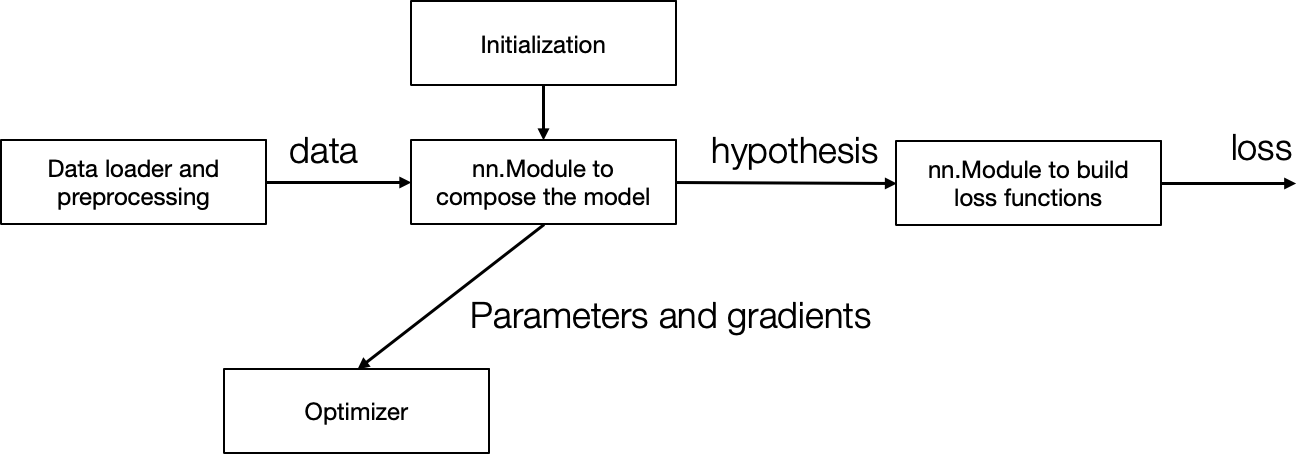

### `nn.Module` interface

Let's start with the `Module` interface. We first introduce a parameter class to indicate a `Tensor` is a trainable parameter. 

In [27]:
class Parameter(ndl.Tensor):
    """parameter"""

In [28]:
def _get_params(value):
    if isinstance(value, Parameter):
        return [value]
    if isinstance(value, dict):
        params = []
        for k, v in value.items():
            params += _get_params(v) # recursion
        return params
    if isinstance(value, Module):
        return value.parameters()
    return []

class Module:
    def parameters(self):
        return _get_params(self.__dict__)

    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)

Now that we have the base Module interface, we can start to define different kind of modules. Let us define a simple scale add module, that computes $y = x \times s + b$. `ScaleAdd` is parameterized by $s$ and $b$.

In [29]:
class ScaleAdd(Module):
    def __init__(self, init_s=1, init_b=0):
        self.s = Parameter([init_s], dtype="float32")
        self.b = Parameter([init_b], dtype="float32")
    
    def forward(self, x):
        return x * self.s + self.b

In [30]:
sadd = ScaleAdd()
sadd.parameters()

[needle.Tensor([1.]), needle.Tensor([0.])]

In [31]:
sadd(2.5)

needle.Tensor([2.5])

We allow a module to contain multiple submodules inside and compose them together

In [32]:
class MultiPathScaleAdd(Module):
    def __init__(self):
        self.path0 = ScaleAdd()
        self.path1 = ScaleAdd()

    def forward(self, x):
        return self.path0(x) + self.path1(x)

In [34]:
mpath = MultiPathScaleAdd()
mpath.parameters()

[needle.Tensor([1.]),
 needle.Tensor([0.]),
 needle.Tensor([1.]),
 needle.Tensor([0.])]

### Loss function

**Note**: fill in your autodiff implementation in hw1, restart the runtime in order to run the following piece of code.

A loss function is implemented as a (subclass of) `Module` **without** parameters.

In [33]:
class L2Loss(Module):
    def forward(self, x ,y):
        z = x + (-1) * y
        return z * z

In [37]:
x = y = ndl.Tensor([2], dtype="float32")
loss = L2Loss()(mpath(x), y)

In [39]:
loss.backward()

In [40]:
params = mpath.parameters()
params[0].grad

needle.Tensor([8.])

### Optimizer

We are now ready to define the optimizer interface. There are two key functions here:
- `reset_grad`: reset the gradient fields of each the the parameters
- `step`: update the parameters

In [41]:
class Optimizer:
    def __init__(self, params):
        self.params = params

    def reset_grad(self):
        for p in self.params:
            p.grad = None
        
    def step(self):
        raise NotImplementedError

In [42]:
class SGD(Optimizer):
    def __init__(self, params, lr):
        self.params = params
        self.lr = lr

    def step(self):
        for w in self.params:
            w.data = w.data + (-self.lr) * w.grad

In [43]:
x = ndl.Tensor([2], dtype="float32")
y = ndl.Tensor([2], dtype="float32")

model = MultiPathScaleAdd()
l2loss = L2Loss()
opt = SGD(model.parameters(), lr=0.01)
num_epoch = 10

for epoch in range(num_epoch):
    opt.reset_grad()
    h = model(x)
    loss = l2loss(h, y)
    training_loss = loss.numpy() # logging
    loss.backward()
    opt.step()

    print(training_loss)

[4.]
[2.5600004]
[1.6384]
[1.0485764]
[0.6710887]
[0.4294967]
[0.27487785]
[0.17592174]
[0.11258985]
[0.07205748]


### Initialization

In the homework, you will need to implement the intialization function for the weight in linear transformations. Under a linear relu network where $\boldsymbol{y}^{(l)} = \boldsymbol{x}^{(l-1)} \mathbf{W}^\mathsf{T}, \boldsymbol{x}^{(l)} = \max(\boldsymbol{y}^{(l)}, \boldsymbol{0})$. Assume that $\mathbf{W} \in \mathbb{R}^{n_\text{out} \times n_\text{in}}$. A common way to do so is to intialize it as $\mathcal{N}(0, \sigma^2)$ where $\sigma = \sqrt{\frac{2}{n_\text{in}}}$.

Check out explaination from the original paper [Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification](https://arxiv.org/abs/1502.01852)

\begin{equation}
 y_i = \sum_{j=1}^{n_{in}} x_j W_{i, j}   
\end{equation}


\begin{equation}
 \mbox{Var}[y_i] =  n_{in} E[x_0^2] \mbox{Var}[W_{i, j}] = n_{in} E[x_0^2] \sigma^2
\end{equation}

Considering the fact that x is also a result of relu of previous layer 

\begin{equation}
 E[x_0^2] = E[relu(y^{(l-1)})^2] = \frac{1}{2}  \mbox{Var}[y^{(l-1)}]
\end{equation}

We can get the variance value by requiring $\mbox{Var}[y^{(l)}] = \mbox{Var}[y^{(l-1)}]$.
NOTE: the variance value was derived under a specific deep relu network.

## Additional contents on programming model

In this section, we will review additional contents on autograd that we may need in future lectures.




### Fused operator and Tuple Value

Up until now each of the needle operator only returns a single output Tensor. In real world application scenarios, it is somtimes helpful to compute many outputs at once in a single (fused) operator.

Needle is designed to support this feature. In order to do so, we need to introduce a new kind of Value -- Tuple.

Open up the files on the left side panel, review the the following changes 
- `autograd.py`: The TensorTuple class
- `ops.py`: TupleGetItemOp and MakeTupleOp

In [51]:
x = ndl.Tensor([1], dtype="float32")

In [53]:
z = ndl.ops.fused_add_scalars(x, 1, 2)

In [54]:
v0 = z[0]

In [ ]:
v0.op